Copyright (C) 2022 Jørgen Schartum Dokken

This file is part of Oasisx
SPDX-License-Identifier:    MIT

# Application of Dirichlet BCs
Illustrates how to apply bcs to the component of the tentative velocity equation.
We compare two strategies:
1. Using matrix-vector products of pre-assembled matrices to compute the RHS
2. Assemble the matrix and vector separately
We start by importing the necessary modules


In [2]:
# This is a test to check notebooks
import matplotlib.pyplot as plt
import time
import seaborn
import pandas
import dolfinx
from mpi4py import MPI
from petsc4py import PETSc
import ufl
import numpy as np
import typing

In [3]:
def assembly(mesh, P: int, repeats: int, jit_options: typing.Optional[dict] = None):
    V = dolfinx.fem.FunctionSpace(mesh, ("CG", int(P)))

    def f(x):
        return 2*np.sin(x[0])+3+2*x[1]
    mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
    boundary_facets = dolfinx.mesh.exterior_facet_indices(mesh.topology)
    boundary_dofs = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim-1, boundary_facets)
    g = dolfinx.fem.Function(V)
    g.interpolate(f)
    bcs = [dolfinx.fem.dirichletbc(g, boundary_dofs)]

    dt = 0.5
    nu = 0.3
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    # Solution from previous time step
    u_1 = dolfinx.fem.Function(V)
    u_1.interpolate(lambda x: np.sin(x[0])*np.cos(x[1]))

    # Define variational forms
    mass = ufl.inner(u, v) * ufl.dx
    stiffness = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx

    u_ab = [dolfinx.fem.Function(V, name=f"u_ab{i}") for i in range(mesh.geometry.dim)]
    convection = ufl.inner(ufl.dot(ufl.as_vector(u_ab), ufl.nabla_grad(u)), v) * ufl.dx
    for u_abi in u_ab:
        u_abi.interpolate(lambda x: x[0])

    # Compile forms for matrix vector products
    jit_options = {} if jit_options is None else jit_options
    mass_form = dolfinx.fem.form(mass, jit_options=jit_options)
    stiffness_form = dolfinx.fem.form(stiffness, jit_options=jit_options)
    convection_form = dolfinx.fem.form(convection, jit_options=jit_options)

    # Compile form for vector assembly (action)
    dt_inv = dolfinx.fem.Constant(mesh, 1./dt)
    dt_inv.name = "dt_inv"
    nu_c = dolfinx.fem.Constant(mesh, nu)
    nu_c.name = "nu"
    rhs = dt_inv * mass - 0.5 * nu_c * stiffness - 0.5*convection
    rhs_form = dolfinx.fem.form(ufl.action(rhs, u_1), jit_options=jit_options)

    # Assemble time independent matrices
    # Mass matrix
    M = dolfinx.fem.petsc.create_matrix(mass_form)
    M.setOption(PETSc.Mat.Option.SYMMETRIC, True)
    M.setOption(PETSc.Mat.Option.SYMMETRY_ETERNAL, True)
    M.setOption(PETSc.Mat.Option.IGNORE_ZERO_ENTRIES, True)
    dolfinx.fem.petsc.assemble_matrix(M, mass_form)
    M.assemble()
    M.setOption(PETSc.Mat.Option.NEW_NONZERO_LOCATIONS, False)

    # Stiffness matrix
    K = dolfinx.fem.petsc.create_matrix(stiffness_form)
    K.setOption(PETSc.Mat.Option.SYMMETRIC, True)
    K.setOption(PETSc.Mat.Option.SYMMETRY_ETERNAL, True)
    K.setOption(PETSc.Mat.Option.IGNORE_ZERO_ENTRIES, True)
    dolfinx.fem.petsc.assemble_matrix(K, stiffness_form)
    K.assemble()
    K.setOption(PETSc.Mat.Option.NEW_NONZERO_LOCATIONS, False)

    # RHS vectors
    b = dolfinx.fem.Function(V)
    bx = dolfinx.fem.Function(V)

    # Timing vectors
    oasis_lhs = np.zeros((repeats, mesh.comm.size), dtype=np.float64)
    oasis_rhs = np.zeros((repeats, mesh.comm.size), dtype=np.float64)
    new_lhs = np.zeros((repeats, mesh.comm.size), dtype=np.float64)
    new_rhs = np.zeros((repeats, mesh.comm.size), dtype=np.float64)
    new_total = np.zeros((repeats, mesh.comm.size), dtype=np.float64)
    oasis_total = np.zeros((repeats, mesh.comm.size), dtype=np.float64)

    A_sp = dolfinx.fem.create_sparsity_pattern(mass_form)
    A_sp.assemble()

    A = dolfinx.cpp.la.petsc.create_matrix(mesh.comm, A_sp)
    Ax = dolfinx.cpp.la.petsc.create_matrix(mesh.comm, A_sp)
    D = dolfinx.cpp.la.petsc.create_matrix(mesh.comm, A_sp)
    D.assemble()
    for i in range(repeats):
        mesh.comm.Barrier()
        # --------------Oasis approach-------------------------
        # Zero out time-dependent matrix
        start_mat = time.perf_counter()
        A.zeroEntries()
        A.setOption(PETSc.Mat.Option.KEEP_NONZERO_PATTERN, True)
        A.setOption(PETSc.Mat.Option.IGNORE_ZERO_ENTRIES, False)
        end_mat = time.perf_counter()

        # Add convection term
        start_lhs = time.perf_counter()
        dolfinx.fem.petsc.assemble_matrix(A, convection_form)
        A.assemble()
        A.scale(-0.5)
        A.axpy(1./dt, M, PETSc.Mat.Structure.SUBSET_NONZERO_PATTERN)
        A.axpy(-0.5*nu, K, PETSc.Mat.Structure.SUBSET_NONZERO_PATTERN)
        end_lhs = time.perf_counter()

        # Do mat-vec operations
        b.x.array[:] = 0
        start_rhs = time.perf_counter()
        A.mult(u_1.vector, b.vector)
        b.x.scatter_reverse(dolfinx.la.InsertMode.add)
        dolfinx.fem.petsc.set_bc(b.vector, bcs)
        b.x.scatter_forward()
        end_rhs = time.perf_counter()
        t_matvec = end_rhs - start_rhs

        mesh.comm.Barrier()
        # Rescale matrix and apply bc
        start_rescale = time.perf_counter()
        A.scale(-1)
        A.axpy(2/dt, M, PETSc.Mat.Structure.SUBSET_NONZERO_PATTERN)
        for bc in bcs:
            A.zeroRowsLocal(bc.dof_indices()[0], 1.)  # type: ignore
        end_rescale = time.perf_counter()
        t_matrix = end_rescale - start_rescale + end_lhs - start_lhs

        mesh.comm.Barrier()

        # Gather results
        oasis_lhs[i, :] = mesh.comm.allgather(t_matrix)
        oasis_rhs[i, :] = mesh.comm.allgather(t_matvec)
        oasis_total[i, :] = mesh.comm.allgather(t_matrix + t_matvec)
        # ---------------------------------------------------------
        # Zero out time-dependent matrix
        Ax.zeroEntries()
        Ax.setOption(PETSc.Mat.Option.KEEP_NONZERO_PATTERN, True)
        Ax.setOption(PETSc.Mat.Option.IGNORE_ZERO_ENTRIES, False)

        mesh.comm.Barrier()

        # Add convection term
        start_lhs_new = time.perf_counter()
        dolfinx.fem.petsc.assemble_matrix(Ax, convection_form)
        Ax.assemble()
        Ax.scale(0.5)
        Ax.axpy(1./dt, M, PETSc.Mat.Structure.SUBSET_NONZERO_PATTERN)
        Ax.axpy(0.5*nu, K, PETSc.Mat.Structure.SUBSET_NONZERO_PATTERN)
        for bc in bcs:
            Ax.zeroRowsLocal(bc.dof_indices()[0], 1.)  # type: ignore
        end_lhs_new = time.perf_counter()

        mesh.comm.Barrier()

        # Compute the vector without using pre-generated matrices
        bx.x.array[:] = 0
        start_rhs_new = time.perf_counter()
        dolfinx.fem.petsc.assemble_vector(bx.vector, rhs_form)
        bx.x.scatter_reverse(dolfinx.la.InsertMode.add)
        dolfinx.fem.petsc.set_bc(bx.vector, bcs)
        bx.x.scatter_forward()
        end_rhs_new = time.perf_counter()

        # Gather results
        new_total[i, :] = mesh.comm.allgather(end_lhs_new - start_lhs_new
                                              + end_rhs_new - start_rhs_new)
        new_lhs[i, :] = mesh.comm.allgather(end_lhs_new - start_lhs_new)
        new_rhs[i, :] = mesh.comm.allgather(end_rhs_new - start_rhs_new)

        matrix_total = mesh.comm.allgather(end_mat-start_mat)
        if mesh.comm.rank == 0:
            print("Oasis Total", oasis_total[i],  "\nNew Total", new_total[i],
                  "\nMatrix total", matrix_total, flush=True)
        # Check that vectors are the same
        if not np.allclose(bx.x.array, b.x.array):
            print(np.max(np.abs(bx.x.array[:]-b.x.array[:])))
            raise RuntimeError("Vectors are not equal after assembly")

        # Check that matrices are the same
        D.zeroEntries()
        A.copy(D, PETSc.Mat.Structure.DIFFERENT_NONZERO_PATTERN)
        D.axpy(-1, Ax, PETSc.Mat.Structure.DIFFERENT_NONZERO_PATTERN)
        if not np.allclose(D.getValuesCSR()[2], 0):
            print(np.max(np.abs(D.getValuesCSR()[2])))
            raise RuntimeError("Matrices are not equal after assembly")
    num_dofs_global = V.dofmap.index_map_bs * V.dofmap.index_map.size_global
    return num_dofs_global, new_lhs, new_rhs, oasis_lhs, oasis_rhs, oasis_total, new_total

We solve the problem on a unit cube that is split into tetrahedras with `Nx`,`Ny` and `Nx`
tetrahera in the x, y and z-direction respectively.

In [4]:
def run_parameter_sweep(Nx: int, Ny: int, Nz: int, repeats: int, min_degree: int,
                        max_degree: int) -> dict:
    # Information regarding optimization flags can be found at:
    # https://gcc.gnu.org/onlinedocs/gcc/Optimize-Options.html
    jit_options = {"cffi_extra_compile_args": ["-march=native", "-O3"]}

    mesh = dolfinx.mesh.create_unit_cube(MPI.COMM_WORLD, Nx, Ny, Nz)
    Ps = np.arange(min_degree, max_degree+1, dtype=np.int32)
    j = 0
    results = {}
    for i, P in enumerate(Ps):
        if mesh.comm.rank == 0:
            print(i, P, flush=True)
        dof, new_lhs, new_rhs, oasis_lhs, oasis_rhs, oasis_total, new_total = assembly(
            mesh, P, repeats=repeats, jit_options=jit_options)
        if mesh.comm.rank == 0:
            print("Writing to dict")
        for row in new_lhs:
            for process in row:
                results[j] = {"P": P, "num_dofs": dof, "method": "new", "side":
                              "lhs", "time (s)": process, "procs": MPI.COMM_WORLD.size}
                j += 1
        for row in new_rhs:
            for process in row:
                results[j] = {"P": P, "num_dofs": dof, "method": "new", "side":
                              "rhs", "time (s)": process, "procs": MPI.COMM_WORLD.size}
                j += 1

        for row in oasis_lhs:
            for process in row:
                results[j] = {"P": P, "num_dofs": dof, "method": "oasis", "side":
                              "lhs", "time (s)": process, "procs": MPI.COMM_WORLD.size}
                j += 1
        for row in oasis_rhs:
            for process in row:
                results[j] = {"P": P, "num_dofs": dof, "method": "oasis", "side":
                              "rhs", "time (s)": process, "procs": MPI.COMM_WORLD.size}
                j += 1
        for row in oasis_total:
            for process in row:
                results[j] = {"P": P, "num_dofs": dof, "method": "oasis", "side":
                              "total", "time (s)": process, "procs": MPI.COMM_WORLD.size}
                j += 1
        for row in new_total:
            for process in row:
                results[j] = {"P": P, "num_dofs": dof, "method": "new", "side":
                              "total", "time (s)": process, "procs": MPI.COMM_WORLD.size}
                j += 1
    return results

We use `pandas` and `seaborn` to visualize the results

In [5]:


def create_plot(results: dict, outfile: str):
    if MPI.COMM_WORLD.rank == 0:
        df = pandas.DataFrame.from_dict(results, orient="index")
        df["label"] = "P" + df["P"].astype(str) + " " + \
            df["num_dofs"].astype(str) + " \n Comms: " + df["procs"].astype(str)
        plt.figure()
        df_rhs = df[df["side"] == "rhs"]
        plot = seaborn.catplot(data=df_rhs, kind="swarm",  x="label",
                               y="time (s)", hue="method")
        plot.set(yscale="log", title="RHS assembly")
        plt.grid()
        plt.savefig(f"{outfile}_rhs.png")

        plt.figure()
        df_lhs = df[df["side"] == "lhs"]
        plot = seaborn.catplot(data=df_lhs, kind="swarm",  x="label",
                               y="time (s)", hue="method")
        plot.set(yscale="log", title="LHS assembly")
        plt.grid()
        plt.savefig(f"{outfile}_lhs.png")

        plt.figure()
        df_total = df[df["side"] == "total"]
        plot = seaborn.catplot(data=df_total, kind="swarm",  x="label",
                               y="time (s)", hue="method")
        plot.set(yscale="log", title="Total assembly")
        plt.grid()
        plt.savefig(f"{outfile}_total.png")

0 1
Oasis Total [0.29781801] 
New Total [0.33253817] 
Matrix total [0.0005647840007441118]
Oasis Total [0.24810714] 
New Total [0.29810394] 
Matrix total [0.000599565013544634]
Oasis Total [0.25231691] 
New Total [0.30612628] 
Matrix total [0.00030913799128029495]
Writing to dict
1 2
Oasis Total [1.84589368] 
New Total [1.86200133] 
Matrix total [0.007748179996269755]
Oasis Total [1.89081544] 
New Total [1.72860732] 
Matrix total [0.008613113997853361]
Oasis Total [2.07813128] 
New Total [1.67060887] 
Matrix total [0.006643058994086459]
Writing to dict
2 3
Oasis Total [8.84440693] 
New Total [8.42270827] 
Matrix total [0.044351614007609896]
Oasis Total [8.59695277] 
New Total [7.86087675] 
Matrix total [0.043045533006079495]
Oasis Total [8.12011877] 
New Total [8.1061614] 
Matrix total [0.04390901399892755]
Writing to dict


<Figure size 640x480 with 0 Axes>

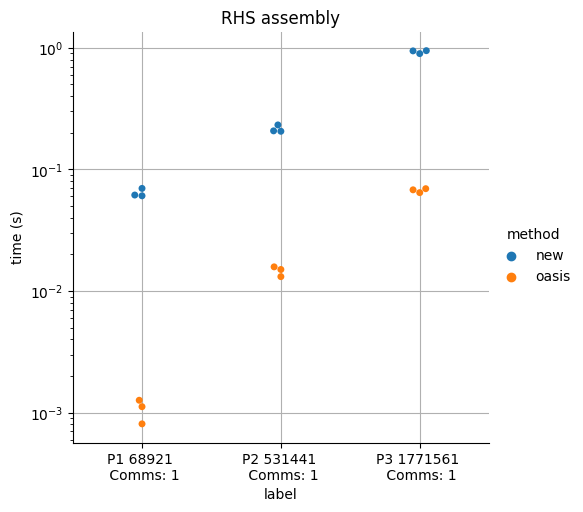

<Figure size 640x480 with 0 Axes>

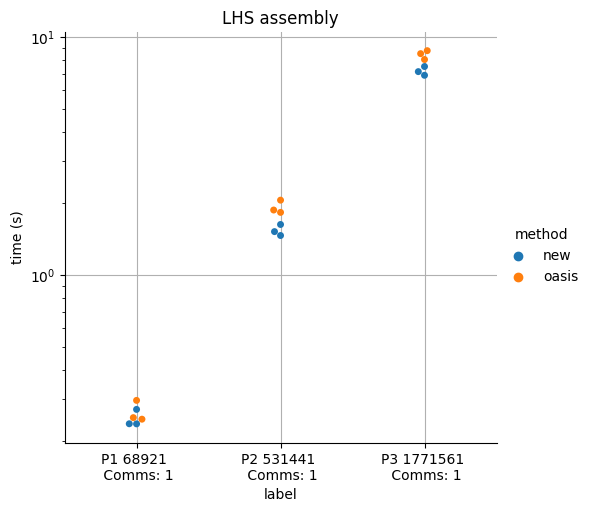

<Figure size 640x480 with 0 Axes>

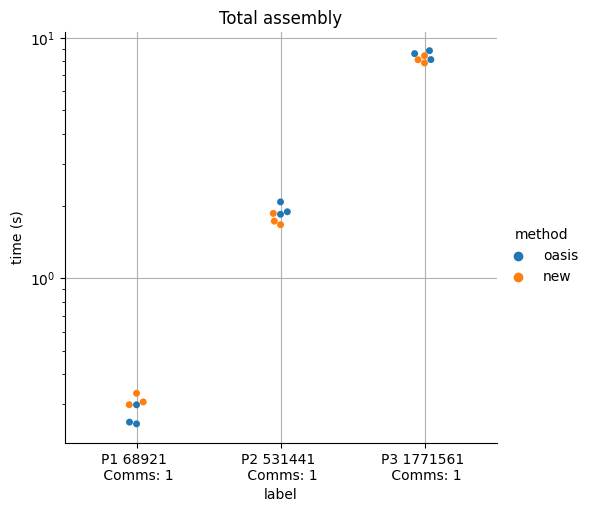

In [6]:
# We start by running the comparison for an increasing number of degrees of freedom on a fixed grid.
if __name__ == "__main__":
    N = 40
    results_p = run_parameter_sweep(N, N, N, repeats=3, min_degree=1, max_degree=3)
    create_plot(results_p, "results")